# Lecture 3: Treatment Effects Estimation under Unconfoundedness

- Unconfoundedness assumption.
- Stratified estimator.
- Propensity score.
- IPW estimator.
- Bootstrap.
- Balance checks.

## Unconfoundedness Assumption

In our hypothetical scenario, we were assuming that we could run an RCT where we could randomly assign our variable of interest (late status of a delivery in our example). In the real world, however, this is rarely possible. Moreover, the independence assumption:

$$\{Y_i(0), Y_i(1)\} \perp\!\!\!\!\perp W_i$$

is usually hard to defend. Suppose we have customers who live in "retirement" areas, more isolated higher-income zones in contrast to  urban, busy zones. These customers tend to be higher income and place larger and heavier orders in the platform due to a lack of other alternatives, and are more profitable for us. However, these larger orders tend to take a longer time to fulfill and deliver, and so we would expect to see these customers receiving disproportionately more late deliveries. If we also consider the fact that there might be less shoppers willing to fulfill the order, the likelihood of lateness is even higher. 

We will, however, assume that there exists some set of *observable, pre-treatment covariates* $X_i$ such that, after conditioning on $X_i$, the treatment $W_i$ is as good as random. This weaker assumption is referred to as **Unconfoundedness**.

$$\{Y_i(0), Y_i(1)\} \perp\!\!\!\!\perp W_i | X_i$$

The covariates $X_i$ are typically referred to as **confounders**. Without accounting for them, our simple treatment effect estimators will be biased. Unconfoundedness is still an untestable assumption, but since it is much weaker than full independence, it is also more defensible.

## Stratified Estimator

How do we account or "control" for $X_i$ in our treatment effect estimation? In its purest sense, unconfoundedness means that we have separate RCTs for each different value of $X_i$. That is, within each value of $X_i$, the units in the control group are acceptable counterfactuals of the units in the treatment group. Intuitively, it seems that we can first estimate the average treatment effect for each different value of $X_i$, that is, the **conditional average treatment effect** and then aggregate them to estimate the average treatment effect. This is easiest to understand when $X_i$ is discrete, that is, $X_i \in \mathcal{X}$ with $|\mathcal{X}| < \infty$ and we can clearly define its segments or **strata** (in our example above, living in a retirement area or not). The **stratified estimator** is defined as:

$$\hat{\tau}_{STRAT} = \sum_{x \in \mathcal{X}} \frac{n_x}{n} \hat{\tau}(x), \qquad {\hat{\tau}}(x) = \frac{1}{n_{x1}}\sum_{X_i = x, W_i = 1} Y_i - \frac{1}{n_{x0}}\sum_{X_i=x, W_i = 0} Y_i$$

This is essentially estimating, for each stratum $x$, the conditional average treatment effect using difference-in-means. Within each stratum, RCT assumptions hold, so difference-in-means is valid. Once we get valid estimates for each stratum, we aggregate them by weighting them according to the weight of the stratum in the sample, $\frac{n_x}{n}$. It can be shown that, if $\frac{n_x}{n}$ reasonably estimates the population weight, $\hat{\tau}_{STRAT}$ is unbiased for the average treatment effect $\tau$.

Remarkably, we are not restricted to use difference-in-means. $\hat{\tau}_{STRAT}$ remains a valid estimator for $\tau$ as long as the method used to obtain the estimate for $\tau(x)$ is valid. This includes using other covariates unrelated to the unconfoundedness for variance reduction in a linear regression setting!

We can obtain an expression for the asymptotic variance of this estimator invoking the Central Limit Theorem:

$$\sqrt{n}(\hat{\tau}_{STRAT} - \tau) \implies \mathcal{N}(0, \mathbb{V}_{STRAT}), \qquad \mathbb{V}_{STRAT} = \mathbb{V}[\tau(X_i)] +\mathbb{E}\left[\frac{\sigma^2_1(X_i)}{e(X_i)} + \frac{\sigma^2_0(X_i)}{1-e(X_i)}\right]$$

where $\sigma^2_1(X_i) = \mathbb{V}[Y_i(1)|X_i]$, $\sigma^2_0(X_i) = \mathbb{V}[Y_i(0)|X_i]$ and $e(X_i) = \mathbb{P}[W_i = 1|X_i]$. Note that the asymptotic variance does not depend on the number of strata!

## Propensity Score

The above derivations work well when $X_i$ is discrete and the strata are well defined such as our example above. But in many cases, the confounders are continuous variables, and it will be impossible to estimate something exactly as $\hat{\tau}_{STRAT}$ defined above, as we will not have access to enough observations for each possible value of $X_i$, less so if $X_i$ is multi-dimensional (think about age, income, historical activity on the platform), 

Luckily for us, in such situations, it suffices to condition on the **propensity score**, $e(X_i)$. The propensity score is the probability of receiving treatment conditioning on $X_i$:

$$e(x) = \mathbb{P}[W_i = 1|X_i = x]$$

It can be shown that:

$$\mathbb{P}[W_i = w|Y_i(w), e(X_i)] = \mathbb{P}[W_i = w|X_i]$$

The fact that it is enough to control for the propensity score makes obtaining a stratified estimator more appealing. We could partition our observations into strata delimited by the value of the propensity score and using our estimator $\hat{\tau}_{STRAT}$.

## Inverse-Propensity Weighting (IPW) Estimator

There is an alternative non-parametric estimator that uses propensity scores, simpler and less discretionary than the stratified estimator. This estimator is called **Inverse-Propensity Weighting (IPW)**, and we can think of it as a modification of the difference-in-means estimator where we weigh units differently based on the values of the propensity scores. The IPW estimator is defined as:

$$\hat{\tau}^*_{IPW} = \frac{1}{n}\sum_{i} \left( \frac{W_i Y_i}{e(X_i)} - \frac{(1-W_i)Y_i}{1-e(X_i)}\right)$$

We can also think of the IPW estimator as the average of "scores", $\Gamma_{i, IPW^*}$ (this is useful for a number of reasons we will see later):

$$\hat{\tau}^*_{IPW} = \frac{1}{n}\sum_{i} \Gamma_{i, IPW^*}, \qquad \Gamma_{i, IPW^*} =\left( \frac{W_i Y_i}{e(X_i)} - \frac{(1-W_i)Y_i}{1-e(X_i)}\right)$$

Let's see if this is a valid estimator for $\tau$:

\begin{align*}\
\mathbb{E}[\hat{\tau}^*_{IPW}] &= \mathbb{E}\left[\frac{1}{n}\sum_{i} \Gamma_{i, IPW^*}\right]\\
\mathbb{E}[\hat{\tau}^*_{IPW}] &= \mathbb{E}\left[\frac{W_i Y_i}{e(X_i)} - \frac{(1-W_i)Y_i}{1-e(X_i)}\right]\\
\mathbb{E}[\hat{\tau}^*_{IPW}] &= \mathbb{E}\left[\frac{W_i Y_i(1)}{e(X_i)} - \frac{(1-W_i)Y_i(0)}{1-e(X_i)}\right]\\
\end{align*}

Now let's use the unconfoundedness assumption:

\begin{align*}\
\mathbb{E}[\hat{\tau}^*_{IPW}] &= \mathbb{E}\left[\frac{W_i Y_i(1)}{e(X_i)} - \frac{(1-W_i)Y_i(0)}{1-e(X_i)}\right]\\
\mathbb{E}[\hat{\tau}^*_{IPW}] &= \mathbb{E}\left[\mathbb{E}\left[\frac{W_i Y_i(1)}{e(X_i)}|X_i\right] - \mathbb{E}\left[\frac{(1-W_i)Y_i(0)}{1-e(X_i)}|X_i\right]\right]\\
\mathbb{E}[\hat{\tau}^*_{IPW}] &= \mathbb{E}\left[\frac{\mathbb{E}\left[W_i Y_i(1)|X_i\right]}{e(X_i)} - \frac{\mathbb{E}\left[(1-W_i) Y_i(0)|X_i\right]}{1-e(X_i)}\right]\\
\mathbb{E}[\hat{\tau}^*_{IPW}] &= \mathbb{E}\left[\frac{\mathbb{E}\left[W_i|X_i\right] \mathbb{E}\left[Y_i(1)|X_i\right]}{e(X_i)} - \frac{\mathbb{E}\left[(1-W_i)|X_i\right] \mathbb{E}\left[Y_i(0)|X_i\right]}{1-e(X_i)}\right]\\
\mathbb{E}[\hat{\tau}^*_{IPW}] &= \mathbb{E}\left[\frac{\mathbb{P}\left[W_i|X_i\right] \mathbb{E}\left[Y_i(1)|X_i\right]}{e(X_i)} - \frac{\mathbb{P}\left[(1-W_i)|X_i\right] \mathbb{E}\left[Y_i(0)|X_i\right]}{1-e(X_i)}\right]\\
\mathbb{E}[\hat{\tau}^*_{IPW}] &= \mathbb{E}\left[\frac{e(X_i) \mathbb{E}\left[Y_i(1)|X_i\right]}{e(X_i)} - \frac{(1-e(X_i)) \mathbb{E}\left[Y_i(0)|X_i\right]}{1-e(X_i)}\right]\\
\mathbb{E}[\hat{\tau}^*_{IPW}] &= \mathbb{E}\left[\mathbb{E}\left[Y_i(1) - Y_i(0)|X_i\right]\right]\\
\mathbb{E}[\hat{\tau}^*_{IPW}] &= \tau\\
\end{align*}

Under unconfoundedness (and SUTVA), $\hat{\tau}^*_{IPW}$ is unbiased for $\tau$. Moreover, because $\hat{\tau}^*_{IPW}$ is the sum of $iid$ scores $\Gamma_{i, IPW^*}$, we can directly apply the Central Limit Theorem to obtain the limiting distribution:

$$\sqrt{n}(\hat{\tau}^*_{IPW} - \tau) \implies \mathcal{N}(0, \mathbb{V}_{IPW*}), \qquad \mathbb{V}_{IPW^*} = \mathbb{V}[\tau(X_i)] +\mathbb{E}\left[\frac{\sigma^2_1(X_i)}{e(X_i)} + \frac{\sigma^2_0(X_i)}{1-e(X_i)}\right] + \mathbb{E}\left[\frac{\left[\mu_0(X_i)+(1-e(X_i))\tau(X_i)\right]^2}{e(X_i)(1-e(X_i))}\right]$$

where $\mu_w(X_i)$ is the part of the potential outcome $Y_i(w)$ that can be explained with $X_i$, that is, $Y_i(w) = \mu_w(X_i) + \varepsilon_i(w)$ with $\varepsilon_i(w)$ being the ($iid$) random component.

Essentially, IPW is rebalancing our units by assigning more weight to those units whose treatment status is more "rare": among the units that received treatment, those with a lower propensity score (and hence with a lower chance of receiving treatment) will have a higher weight. This process attempts to undo the selection in the DGP.  

One important thing to note here is that IPW makes gives us a simple valid way to estimate treatment effects under unconfoundedness, but we pay a price in terms of variance. In a setting where $\hat{\tau}_{STRAT}$ is well-defined, it is straight-forward to see that:

$$V_{IPW^*} = V_{STRAT} + \mathbb{E}\left[\frac{\left[\mu_0(X_i)+(1-e(X_i))\tau(X_i)\right]^2}{e(X_i)(1-e(X_i))}\right]$$

so IPW actually performs worse than the stratified-estimator in such settings.

Another drawback of IPW is that it is very sensitive to extreme values of the propensity score. In fact, if for some value of $X_i$ the propensity score is $0$ or $1$, IPW can't be defined. We typically address this problem by requiring the propensity score to not have such extreme values, invoking what we refer to as an "overlap" assumption. That is, we assume that there exists an $\eta >0$ such that: 

$$\eta \leq e(x) \leq 1-\eta \text{ for all } x \in \mathcal{X}$$

This is called the "strong overlap" assumption and it will have implications in how we use IPW in practice. There are some estimators similar to IPW that require a weaker overlap assumption (referred to as "weak overlap"). Assuming strong overlap is fine for our purposes so whenever we think of "overlap", we will be referring to the strong overlap assumption. 

Let's see how this all works. Let's introduce a modification to the DGP from our previous exercise that lifts the RCT assumption.

\begin{align*}
i &= 1,\ldots, n\\
X_{ij} &\overset{iid}{\sim} \mathcal{U}(-1, 1), \; j \in \{1,2,3\}\\
e(X_i) &= 0.1 + 0.85 * \sqrt{\frac{\text{max}\{0,1+X_{2i}+X_{3i}\}}{3}}\\
W_i &\sim Ber(e(X_i))\\
Y_i &= \text{exp}(X_{1i} + X_{2i}) + \text{max}\{0,X_{3i}\} W_i  
\end{align*}

The average treatment effect in this setting is the same as before:

\begin{align*}
\tau &= \mathbb{E}[Y_i(1) - Y_i(0)]\\
\tau &= \mathbb{E}[\text{exp}(X_{1i} + X_{2i}) + \text{max}\{0,X_{3i}\} - \text{exp}(X_{1i} + X_{2i})]\\
\tau &= \mathbb{E}[\text{max}\{0,X_{3i}\}]\\
\tau &= \mathbb{E}[\text{max}\{0,X_{3i}\}|X_{3i} \geq 0]\mathbb{P}[X_{3i}\geq 0] + \mathbb{E}[\text{max}\{0,X_{3i}\}|X_{3i}<0]\mathbb{P}[X_{3i}<0]\\
\tau &= \underbrace{\mathbb{E}[\text{max}\{0,X_{3i}\}|X_{3i} \geq 0]}_{0.5}\underbrace{\mathbb{P}[X_{3i}\geq 0]}_{0.5} + 0\\
\tau &= 0.25
\end{align*}

In [1]:
import dgp_simulation
import estimators
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter

def disable_sci(ax):
    ax.ticklabel_format(style="plain", axis="both", useOffset=False)
    ax.xaxis.set_major_formatter(ScalarFormatter())
    ax.yaxis.set_major_formatter(ScalarFormatter())

In [2]:
base_params = {
    "p": 0.5,
    "n": 100_000,
    "seed": 42,
    "rct": False,
}

In [3]:
obs_df = dgp_simulation.simulate_dgp(**base_params)
obs_df.head()

,W,Y,X1,X2,X3,prop
0,1,2.247810,0.547912,-0.122243,0.717196,0.719772
1,1,1.610325,0.394736,-0.811645,0.951245,0.623883
2,0,2.987414,0.522279,0.572129,-0.743773,0.546649
3,0,0.699330,-0.099228,-0.258404,0.853530,0.719806
4,0,2.542769,0.287730,0.645523,-0.113172,0.707488


What would happen if we tried to estimate $\tau$ with difference-in-means?

In [4]:
estimators.diff_in_means(obs_df)

{'estimate': 0.8117806755938177,
 'std_error': 0.0072475491816618755,
 'ci_95': [0.7975754791977604, 0.825985871989875],
 'ci_size_perc': 3.4997621458939574,
 'p_value': 0.0}

What about linear regression, or Lin's estimator, where we control linearly for $X_i$?

In [5]:
estimators.regression_based(obs_df, cov=["X1", "X2", "X3"])

{'estimate': 0.2164353837541795,
 'std_error': 0.003791410518347556,
 'ci_95': [0.20900426573950343, 0.22386650176885559],
 'ci_size_perc': 6.8668236087645536,
 'p_value': 0.0}

In [6]:
estimators.lin_estimator(obs_df, cov=["X1", "X2", "X3"])

{'estimate': 0.2324388680072816,
 'std_error': 0.003943238242720315,
 'ci_95': [0.2247101695161851, 0.24016756649837812],
 'ci_size_perc': 6.650091318509077,
 'p_value': 0.0}

Looks better, but bias is ~10% of the estimator. Let's try the two new estimators we proposed above, starting with $\hat{\tau}_{IPW}^*$. Note that because CLT holds, we can simply estimate the asymptotic variance with the sample variance of the scores $\Gamma_{i, IPW^*}$.  

In [7]:
estimators.ipw_estimator(obs_df, propensity_col="prop")

{'estimate': 0.25275380602641173,
 'std_error': 0.014355238171034942,
 'ci_95': [0.22461753921118324, 0.2808900728416402],
 'ci_size_perc': 22.263773003116203,
 'p_value': 2.1737884717986452e-69}

So much better! Let's compare this to $\hat{\tau}_{STRAT}$ using the propensity score as stratification variable and 20 strata.  

In [8]:
estimators.stratified_estimator(obs_df, cov="prop", cutoffs=np.linspace(0.1, 0.9, 20).tolist())

{'estimate': 0.258548563091605,
 'strata_df':      bin_low  bin_high  estimate   weight  count
 0       -inf  0.100000       NaN  0.00000      0
 1   0.100000  0.142105  0.005145  0.12717  12717
 2   0.142105  0.184211 -0.101761  0.00558    558
 3   0.184211  0.226316  0.030766  0.00900    900
 4   0.226316  0.268421  0.019131  0.01391   1391
 5   0.268421  0.310526  0.066343  0.01928   1928
 6   0.310526  0.352632  0.004374  0.02474   2474
 7   0.352632  0.394737  0.033002  0.03139   3139
 8   0.394737  0.436842  0.078900  0.03786   3786
 9   0.436842  0.478947  0.099202  0.04847   4847
 10  0.478947  0.521053  0.106201  0.05806   5806
 11  0.521053  0.563158  0.208056  0.06949   6949
 12  0.563158  0.605263  0.259237  0.08235   8235
 13  0.605263  0.647368  0.298498  0.08527   8527
 14  0.647368  0.689474  0.304251  0.08329   8329
 15  0.689474  0.731579  0.323379  0.07833   7833
 16  0.731579  0.773684  0.411479  0.07086   7086
 17  0.773684  0.815789  0.467084  0.05998   5998
 18  

## Bootstrap

Unlike the estimators we have computed so far, there is no immediate way to compute the variance of $\hat{\tau}_{STRAT}$ with a plugin estimator for $V_{STRAT}$. There is, however, a statistical technique that allows us to compute the distribution of almost any estimator through resampling methods: bootstrapping.

Bootstrapping is as conceptually simple as it is powerful. Given an estimator we can compute with a sample, bootstrapping allows to estimate the sampling distribution of the estimator by constructing $B$ new samples through resampling the original data with replacement $B$ times. In each of those new samples, we compute our estimator creating a distribution with the estimates. We then use that distribution to compute different statistics: mean, variance, confidence intervals, etc. Bootstrap. works almost everywhere assuming the observations are $iid$ and the sample is representative from the population we want to make inference of.

We want to use bootstrap to obtain an estimate of the variance and confidence intervals for $\hat{\tau}_{STRAT}$. There are a number of ways to do it, but we will obtain each using the most common method. For the variance, we will compute the sample variance of the estimator across our bootstrapped samples. For the (95%) confidence interval, we will grab the 2.5th and 97.5th percentiles of the bootstrapped distribution. Because we know the limiting distribution of $\hat{\tau}_{STRAT}$ (Normal), we will compare the percentile method of constructing the confidence intervals to simply using the bootstrapped variance.

Let's first evaluate whether bootstrap provides a reasonable estimate of the variance in the cases we can directly compute its expression.

In [9]:
estimators.diff_in_means(obs_df)

{'estimate': 0.8117806755938177,
 'std_error': 0.0072475491816618755,
 'ci_95': [0.7975754791977604, 0.825985871989875],
 'ci_size_perc': 3.4997621458939574,
 'p_value': 0.0}

In [10]:
estimators.bootstrap(obs_df, 1000, estimators.diff_in_means)

{'mean': 0.8118261998952896,
 'std_error': 0.007416932537379515,
 'ci_95_normal': [0.7972890121220257, 0.8263633876685534],
 'ci_95_percentile': [0.7974972816809338, 0.8266316300961084]}

In [11]:
estimators.lin_estimator(obs_df, cov=['X1','X2','X3'])

{'estimate': 0.2324388680072816,
 'std_error': 0.003943238242720315,
 'ci_95': [0.2247101695161851, 0.24016756649837812],
 'ci_size_perc': 6.650091318509077,
 'p_value': 0.0}

In [12]:
estimators.bootstrap(obs_df, 1000, estimators.lin_estimator, cov=['X1','X2','X3'])

{'mean': 0.2324220217520202,
 'std_error': 0.004066994043361613,
 'ci_95_normal': [0.22445071342703143, 0.24039333007700897],
 'ci_95_percentile': [0.22431984600141225, 0.24006694133007878]}

In [13]:
estimators.ipw_estimator(obs_df, propensity_col="prop")

{'estimate': 0.25275380602641173,
 'std_error': 0.014355238171034942,
 'ci_95': [0.22461753921118324, 0.2808900728416402],
 'ci_size_perc': 22.263773003116203,
 'p_value': 2.1737884717986452e-69}

In [14]:
estimators.bootstrap(obs_df, 1000, estimators.ipw_estimator, propensity_col="prop")

{'mean': 0.2526519141331179,
 'std_error': 0.014385680753509593,
 'ci_95_normal': [0.22445597985623908, 0.28084784840999666],
 'ci_95_percentile': [0.2248719047814635, 0.28017822791564834]}

The bootstrapped variance and CI look pretty close to the ones obtained with the plugin estimators, suggesting that the bootstrap technique can provide a way to obtain the sampling distribution. Let's now use this learning and compute the variance and CI for $\hat{\tau}_{STRAT}$:

In [15]:
estimators.stratified_estimator(obs_df, cov="prop", cutoffs=np.linspace(0.1, 0.9, 20).tolist())

{'estimate': 0.258548563091605,
 'strata_df':      bin_low  bin_high  estimate   weight  count
 0       -inf  0.100000       NaN  0.00000      0
 1   0.100000  0.142105  0.005145  0.12717  12717
 2   0.142105  0.184211 -0.101761  0.00558    558
 3   0.184211  0.226316  0.030766  0.00900    900
 4   0.226316  0.268421  0.019131  0.01391   1391
 5   0.268421  0.310526  0.066343  0.01928   1928
 6   0.310526  0.352632  0.004374  0.02474   2474
 7   0.352632  0.394737  0.033002  0.03139   3139
 8   0.394737  0.436842  0.078900  0.03786   3786
 9   0.436842  0.478947  0.099202  0.04847   4847
 10  0.478947  0.521053  0.106201  0.05806   5806
 11  0.521053  0.563158  0.208056  0.06949   6949
 12  0.563158  0.605263  0.259237  0.08235   8235
 13  0.605263  0.647368  0.298498  0.08527   8527
 14  0.647368  0.689474  0.304251  0.08329   8329
 15  0.689474  0.731579  0.323379  0.07833   7833
 16  0.731579  0.773684  0.411479  0.07086   7086
 17  0.773684  0.815789  0.467084  0.05998   5998
 18  

In [16]:
estimators.bootstrap(obs_df, 1000, estimators.stratified_estimator, cov="prop", cutoffs=np.linspace(0.1, 0.9, 20).tolist())

{'mean': 0.25813593359492415,
 'std_error': 0.00767948888023913,
 'ci_95_normal': [0.24308413538965545, 0.27318773180019285],
 'ci_95_percentile': [0.24364881412665929, 0.27272446768305175]}

It seems the empirical results are aligned with our derivations above: $V_{IPW^*} \geq V_{STRAT}$. Let's run simulations to compare their behavior under different values of $n$ and different number of strata (this might take a while).

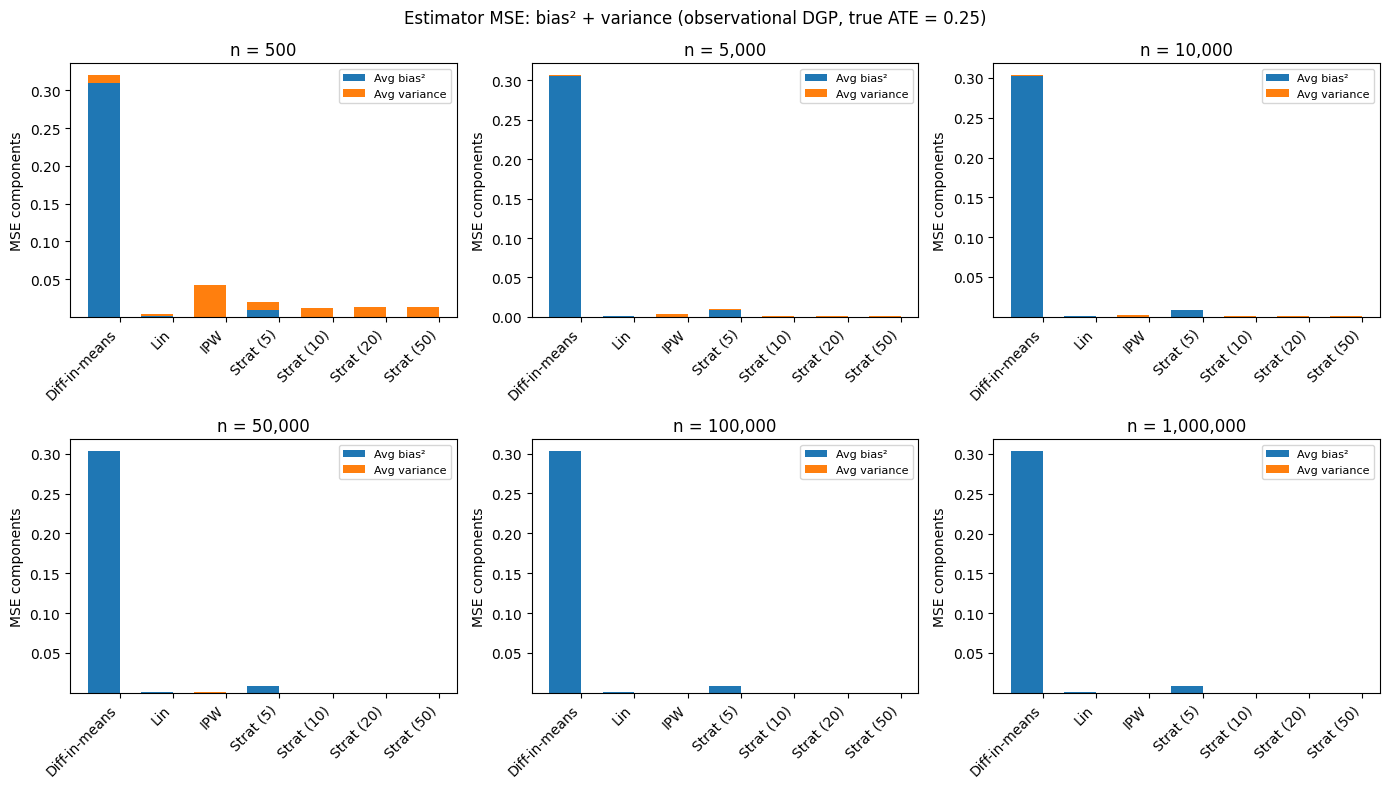

In [17]:
# --- Parameters (edit these) ---
TRUE_ATE = 0.25
n_values = [500, 5_000, 10_000, 50_000, 100_000, 1_000_000]
S = 1000
base_seed = 42

estimator_names = [
    "Diff-in-means",
    "Lin",
    "IPW",
    "Strat (5)",
    "Strat (10)",
    "Strat (20)",
    "Strat (50)",
]

# --- Simulation: for each n, run S datasets and collect estimates per estimator ---
# MSE = bias² + variance. We compute: squared_bias = (E[τ̂] - τ)², variance = E[(τ̂ - E[τ̂])²].
all_avg_sq_bias = []
all_avg_var = []

for n in n_values:
    estimates_per_est = [[] for _ in range(7)]

    for s in range(S):
        params = {"p": 0.5, "n": int(n), "rct": False, "seed": base_seed + s}
        df = dgp_simulation.simulate_dgp(**params)

        # 1. Diff-in-means
        res = estimators.diff_in_means(df)
        estimates_per_est[0].append(res["estimate"])

        # 2. Lin
        res = estimators.lin_estimator(df, cov=["X1", "X2", "X3"])
        estimates_per_est[1].append(res["estimate"])

        # 3. IPW
        res = estimators.ipw_estimator(df, propensity_col="prop")
        estimates_per_est[2].append(res["estimate"])

        # 4–7. Stratified (5, 10, 20, 50 strata)
        for i, n_strata in enumerate([5, 10, 20, 50]):
            cutoffs = np.linspace(0.1, 0.9, n_strata - 1).tolist()
            res = estimators.stratified_estimator(df, cov="prop", cutoffs=cutoffs)
            estimates_per_est[3 + i].append(res["estimate"])

    # Squared bias = (mean(estimates) - τ)²; variance = empirical variance of estimates
    avg_sq_bias = [
        (float(np.nanmean(estimates_per_est[i])) - TRUE_ATE) ** 2
        for i in range(7)
    ]
    avg_var = [float(np.nanvar(estimates_per_est[i])) for i in range(7)]
    all_avg_sq_bias.append(avg_sq_bias)
    all_avg_var.append(avg_var)

# --- Plot 1: all 7 estimators ---
x = np.arange(7)
width = 0.6
fig, axes = plt.subplots(2, 3, figsize=(14, 8))
axes = axes.flatten()

for idx, ax in enumerate(axes):
    bias_vals = np.array(all_avg_sq_bias[idx], dtype=float)
    var_vals = np.array(all_avg_var[idx], dtype=float)
    bias_plot = np.nan_to_num(bias_vals, nan=0.0)
    var_plot = np.nan_to_num(var_vals, nan=0.0)
    ax.bar(x - width / 2, bias_plot, width, label="Avg bias²", color="C0")
    ax.bar(x - width / 2, var_plot, width, bottom=bias_plot, label="Avg variance", color="C1")
    ax.set_xticks(x)
    ax.set_xticklabels(estimator_names, rotation=45, ha="right")
    ax.set_title(f"n = {n_values[idx]:,}")
    ax.set_ylabel("MSE components")
    ax.legend(loc="upper right", fontsize=8)

fig.suptitle("Estimator MSE: bias² + variance (observational DGP, true ATE = 0.25)", fontsize=12)
plt.tight_layout()
plt.show()

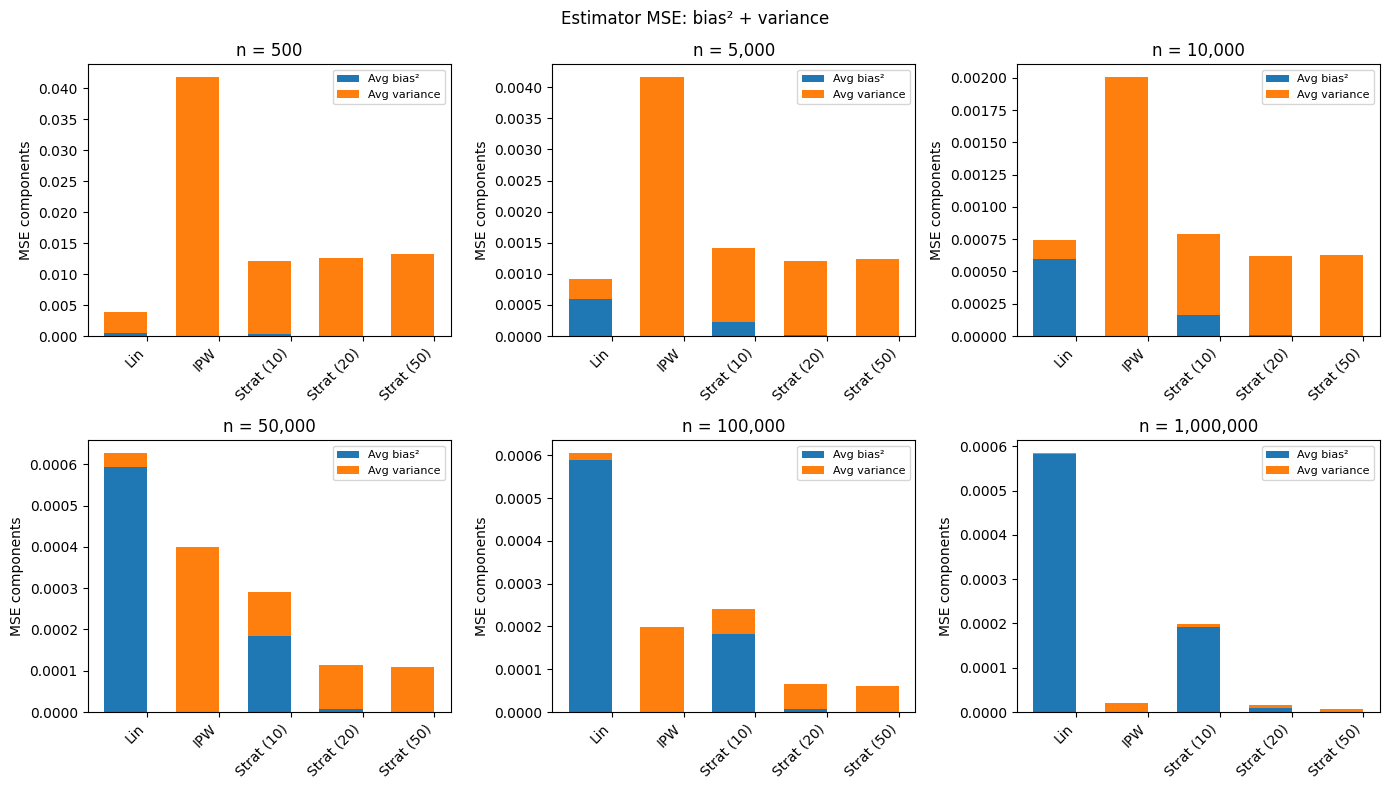

In [18]:
# --- Plot 2: excluding diff-in-means and Strat (5) ---
# Indices: 0=Diff-in-means, 1=Lin, 2=IPW, 3=Strat(5), 4=Strat(10), 5=Strat(20), 6=Strat(50)
include_idx = [1, 2, 4, 5, 6]
plot_names_2 = [estimator_names[i] for i in include_idx]
x = np.arange(len(include_idx))
fig2, axes2 = plt.subplots(2, 3, figsize=(14, 8))
axes2 = axes2.flatten()

for idx, ax in enumerate(axes2):
    bias_vals = np.array([all_avg_sq_bias[idx][i] for i in include_idx], dtype=float)
    var_vals = np.array([all_avg_var[idx][i] for i in include_idx], dtype=float)
    bias_plot = np.nan_to_num(bias_vals, nan=0.0)
    var_plot = np.nan_to_num(var_vals, nan=0.0)
    ax.bar(x - width / 2, bias_plot, width, label="Avg bias²", color="C0")
    ax.bar(x - width / 2, var_plot, width, bottom=bias_plot, label="Avg variance", color="C1")
    ax.set_xticks(x)
    ax.set_xticklabels(plot_names_2, rotation=45, ha="right")
    ax.set_title(f"n = {n_values[idx]:,}")
    ax.set_ylabel("MSE components")
    ax.legend(loc="upper right", fontsize=8)

fig2.suptitle("Estimator MSE: bias² + variance", fontsize=12)
plt.tight_layout()
plt.show()

## Balance checks

Let's take a look at the rebalancing property of $e(X)$. A standard procedure when studying treatment effects is to run a **balance check**. A balance check analyzes the covariate distributions between the treatment and control groups. In a RCT, by design, the covariate distributions among the groups are the same. This amounts to say that the groups are comparable and they are good counterfactuals of each other. In practice, however, sampling errors and/or other shenanigans might threaten the balance of our setting. This is why it is always a good practice to check whether the covariates in our group are balanced or not. If they are not, then we might need to correct the imbalance.

There are multiple ways to help determine whether the sample is imbalanced. In this exercise we will focus on **standardized mean differences**. The concept is very simple: we compute the difference in means for each covariate in the treatment and control groups, and normalize by the standard error of the difference. For a given covariate $X_{ij}$:

$$S = \frac{\mu_{j1} - \mu_{j0}}{\sqrt{\sigma_{j1}^2 + \sigma_{j0}^2}}$$

And this can be estimated straight-forwardly with:

$$\hat{S} = \frac{\bar{X}_{j1} - \bar{X}_{j0}}{\sqrt{s_{j1}^2 + s_{j0}^2}}$$

where $s_{jw}^2$ is the sample variance of covariate $X_j$ for units in the treatment group $w$.

Let's simulate our RCT setting again and check the balance.

\begin{align*}
i &= 1,\ldots, n\\
X_{ij} &\overset{iid}{\sim} \mathcal{U}(-1, 1), \; j \in \{1,2,3\}\\
W_i &\overset{iid}{\sim} Ber(p)\\
Y_i &= \text{exp}(X_{1i} + X_{2i}) + 0.25 W_i  
\end{align*}

In [19]:
rct_params = {
    "p": 0.5,
    "n": 100_000,
    "seed": 42,
    "rct": True,
}

In [20]:
rct_df = dgp_simulation.simulate_dgp(**rct_params)
rct_df.head()

,W,Y,X1,X2,X3
0,0,1.530614,0.547912,-0.122243,0.717196
1,0,0.659081,0.394736,-0.811645,0.951245
2,1,3.237414,0.522279,0.572129,-0.743773
3,1,0.949330,-0.099228,-0.258404,0.853530
4,1,2.792769,0.287730,0.645523,-0.113172


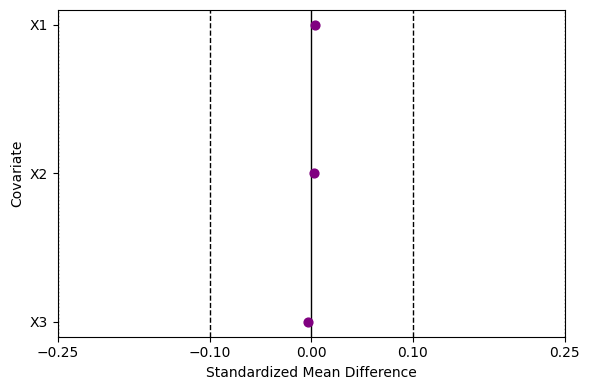

In [21]:
table = dgp_simulation.balance_check(rct_df, cov=["X1", "X2", "X3"])

As expected, covariates are balanced across groups in the RCT setting. What about in the observational dataset?

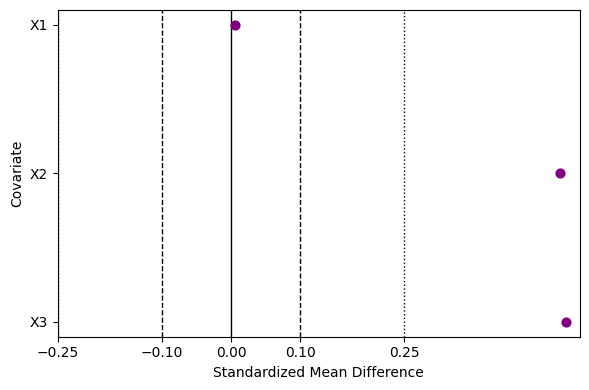

In [22]:
table = dgp_simulation.balance_check(obs_df, cov=["X1", "X2", "X3"])

Balance looks pretty bad. As a rule of thumb, covariates with a standardized difference below 0.10 can be considered balanced across groups.

But what would happen if we reweigh the observations using the (inverse of the) propensity score?

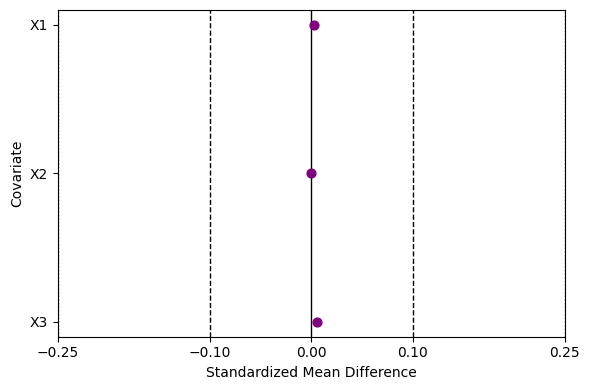

In [23]:
table = dgp_simulation.balance_check(obs_df, cov=["X1", "X2", "X3"], propensity_col="prop")